# Techs to Add
### RSI, MACD, CCI, Bollinger Bands, SMA 9, SMA 20, SMA 50, SMA 100, SMA 200


In [2]:
import pandas as pd
from pandas_datareader import data as web
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from pathlib import Path
import hvplot.pandas


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
file_path = Path("Resources/spy_data_pedro.csv")
spy_df = pd.read_csv(file_path)

In [4]:
spy_px = spy_df[["Date", "SPY Close", "High", "Low"]]
spy_px.head()

,Date,SPY Close,High,Low
0,1/2/2014,161.633575,184.070007,182.479996
1,1/3/2014,161.607040,183.600006,182.630005
2,1/6/2014,161.138702,183.559998,182.080002
3,1/7/2014,162.128388,183.789993,182.949997
4,1/8/2014,162.163788,183.830002,182.889999


## Bollinger Band
##### Def: A Bollinger Band® is a technical analysis tool defined by a set of trendlines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of a security's price, but which can be adjusted to user preferences

In [9]:
bollinger_window = 20
spy_px['bollinger_mid_band'] = spy_px["SPY Close"].rolling(window=bollinger_window).mean()
spy_px.tail()

,Date,SPY Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band
1570,3/30/2020,261.649994,262.429993,253.529999,261.894091,287.550420,236.237762
1571,3/31/2020,257.750000,263.329987,256.220001,259.857351,284.030002,235.684700
1572,4/1/2020,246.149994,257.660004,243.899994,256.613299,277.715422,235.511176
1573,4/2/2020,251.830002,252.679993,244.589996,254.170207,272.553954,235.786460
1574,4/3/2020,248.190002,253.320007,245.220001,251.793654,267.383140,236.204168


In [10]:
bollinger_std = spy_px["SPY Close"].rolling(window=20).std()
spy_px["bollinger_upper_band"] = spy_px["bollinger_mid_band"] + bollinger_std
spy_px["bollinger_lower_band"] = spy_px["bollinger_mid_band"] - bollinger_std

<AxesSubplot:>

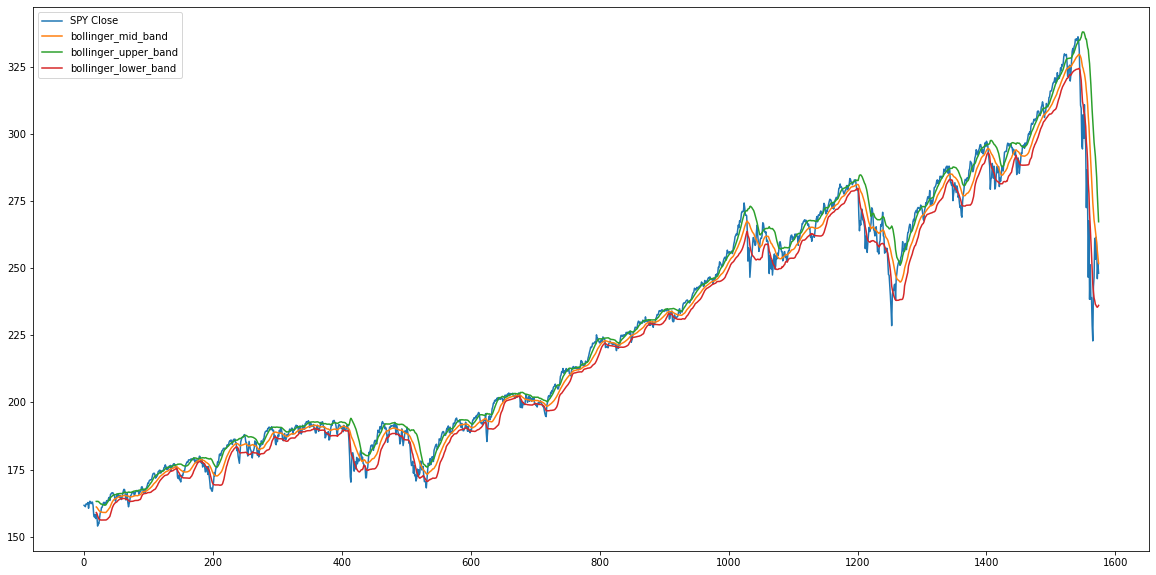

In [11]:
spy_px[["SPY Close",'bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [12]:
spy_px['bollinger_long'] = np.where(spy_px['SPY Close'] < spy_px['bollinger_lower_band'], 1.0, 0.0)
spy_px['bollinger_short'] = np.where(spy_px['SPY Close'] > spy_px['bollinger_upper_band'], -1.0, 0.0)
spy_px['bollinger_signal'] = spy_px['bollinger_long'] + spy_px['bollinger_short']

In [13]:
spy_px.iloc[20:25, :]

,Date,SPY Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
20,1/31/2014,157.445129,179.289993,176.919998,160.825484,163.045499,158.605470,1.0,0.0,1.0
21,2/3/2014,153.901810,178.369995,173.830002,160.440223,163.135235,157.745211,1.0,0.0,1.0
22,2/4/2014,154.979782,175.839996,174.110001,160.132277,163.083019,157.181535,1.0,0.0,1.0
23,2/5/2014,154.785431,175.559998,173.710007,159.765129,162.905185,156.625074,1.0,0.0,1.0
24,2/6/2014,156.826599,177.479996,175.220001,159.498270,162.650513,156.346026,0.0,0.0,0.0


## MACD

In [14]:
macd_df = pd.DataFrame(spy_px[['Date', 'SPY Close']])

# Set short and long SMAs
short_sma = 12
long_sma = 26

# Construct a 'Fast' and 'Slow' Exponentiall Moving Average from short and long windows, respectively
spy_px['macd 12d sma'] = spy_px['SPY Close'].ewm(halflife=short_sma).mean()
spy_px['macd 26d sma'] = spy_px['SPY Close'].ewm(halflife=long_sma).mean()

# Construct a crossover trading signal
spy_px['MACD Long'] = np.where(spy_px['macd 12d sma'] > spy_px['macd 26d sma'], 1.0, 0.0)
spy_px['MACD Short'] = np.where(spy_px['macd 12d sma'] < spy_px['macd 26d sma'], -1.0, 0.0)

# Construct MACD Signal
spy_px['MACD Signal'] = spy_px['MACD Long'] + spy_px['MACD Short']

<AxesSubplot:>

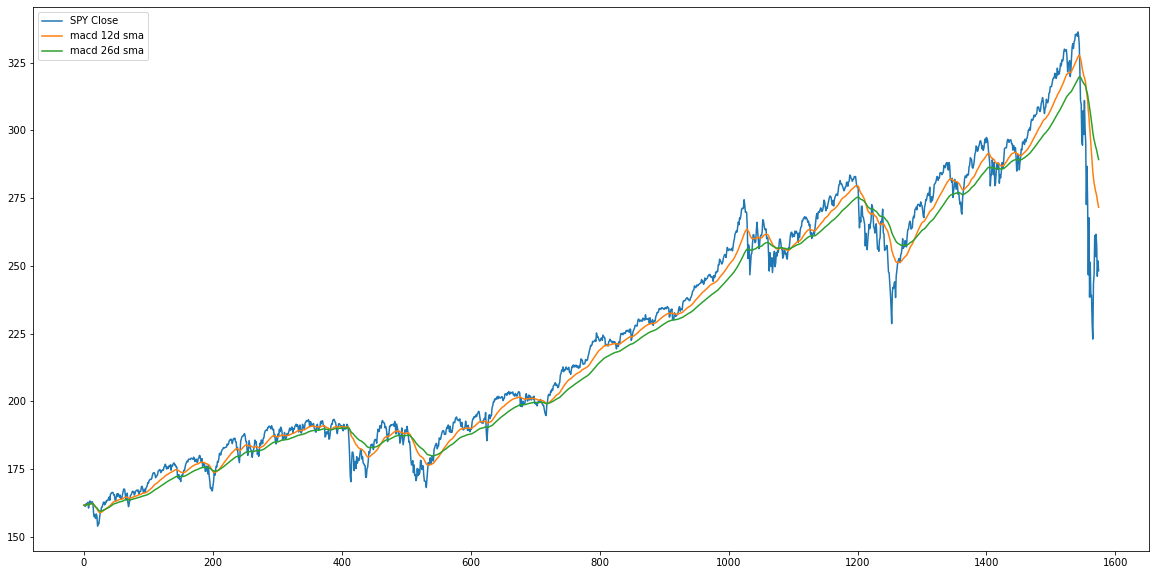

In [16]:
macd_df.tail(20)
spy_px[["SPY Close",'macd 12d sma','macd 26d sma']].plot(figsize=(20,10))

## RSI

In [17]:
rsi_df = pd.DataFrame(spy_px[['Date', 'SPY Close']])

def computeRSI(data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[diff > 0]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[diff < 0]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

spy_px['RSI'] = computeRSI(spy_px['SPY Close'], 14)

In [18]:
# Construct a crossover trading signal
spy_px['RSI Long'] = np.where(spy_px['RSI'] < 30, 1.0, 0.0)
spy_px['RSI Short'] = np.where(spy_px['RSI'] > 70, -1.0, 0.0)

# Construct MACD Signal
spy_px['RSI Signal'] = spy_px['RSI Long'] + spy_px['RSI Short']

In [19]:
spy_px.iloc[14:30, :]

,Date,SPY Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,macd 12d sma,macd 26d sma,MACD Long,MACD Short,MACD Signal,RSI,RSI Long,RSI Short,RSI Signal
14,1/23/2014,161.518722,183.399994,181.820007,NaN,NaN,NaN,0.0,0.0,0.0,162.201766,162.167025,1.0,0.0,1.0,45.814168,0.0,0.0,0.0
15,1/24/2014,158.072571,181.660004,178.830002,NaN,NaN,NaN,0.0,0.0,0.0,161.817526,161.856829,0.0,-1.0,-1.0,29.201997,1.0,0.0,1.0
16,1/27/2014,157.294922,179.520004,177.119995,NaN,NaN,NaN,0.0,0.0,0.0,161.411666,161.527504,0.0,-1.0,-1.0,26.837181,1.0,0.0,1.0
17,1/28/2014,158.231583,179.300003,178.119995,NaN,NaN,NaN,0.0,0.0,0.0,161.135565,161.300009,0.0,-1.0,-1.0,33.791896,0.0,0.0,0.0
18,1/29/2014,156.711746,178.550003,176.880005,NaN,NaN,NaN,0.0,0.0,0.0,160.762920,160.996286,0.0,-1.0,-1.0,28.978382,1.0,0.0,1.0
19,1/30/2014,158.373001,179.809998,178.259995,161.034907,163.112227,158.957587,1.0,0.0,1.0,160.567107,160.829297,0.0,-1.0,-1.0,39.177007,0.0,0.0,0.0
20,1/31/2014,157.445129,179.289993,176.919998,160.825484,163.045499,158.605470,1.0,0.0,1.0,160.317749,160.621629,0.0,-1.0,-1.0,36.062144,0.0,0.0,0.0
21,2/3/2014,153.901810,178.369995,173.830002,160.440223,163.135235,157.745211,1.0,0.0,1.0,159.817184,160.223237,0.0,-1.0,-1.0,27.176201,1.0,0.0,1.0
22,2/4/2014,154.979782,175.839996,174.110001,160.132277,163.083019,157.181535,1.0,0.0,1.0,159.447860,159.922298,0.0,-1.0,-1.0,32.616092,0.0,0.0,0.0
23,2/5/2014,154.785431,175.559998,173.710007,159.765129,162.905185,156.625074,1.0,0.0,1.0,159.098951,159.636365,0.0,-1.0,-1.0,32.149798,0.0,0.0,0.0


<AxesSubplot:>

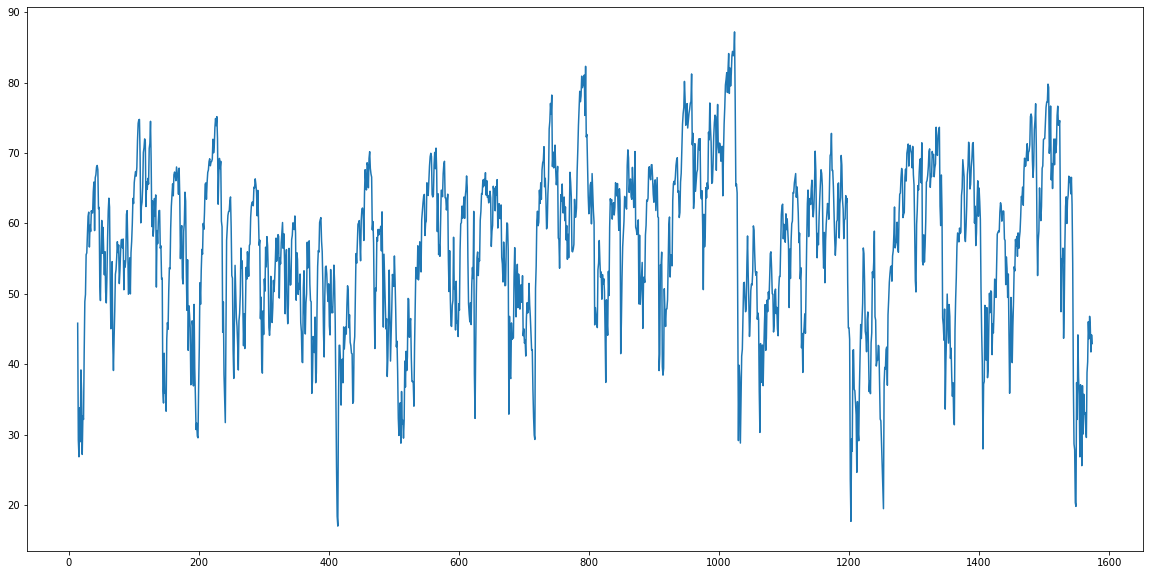

In [20]:
spy_px['RSI'].plot(figsize=(20,10))

## SMAs

<AxesSubplot:>

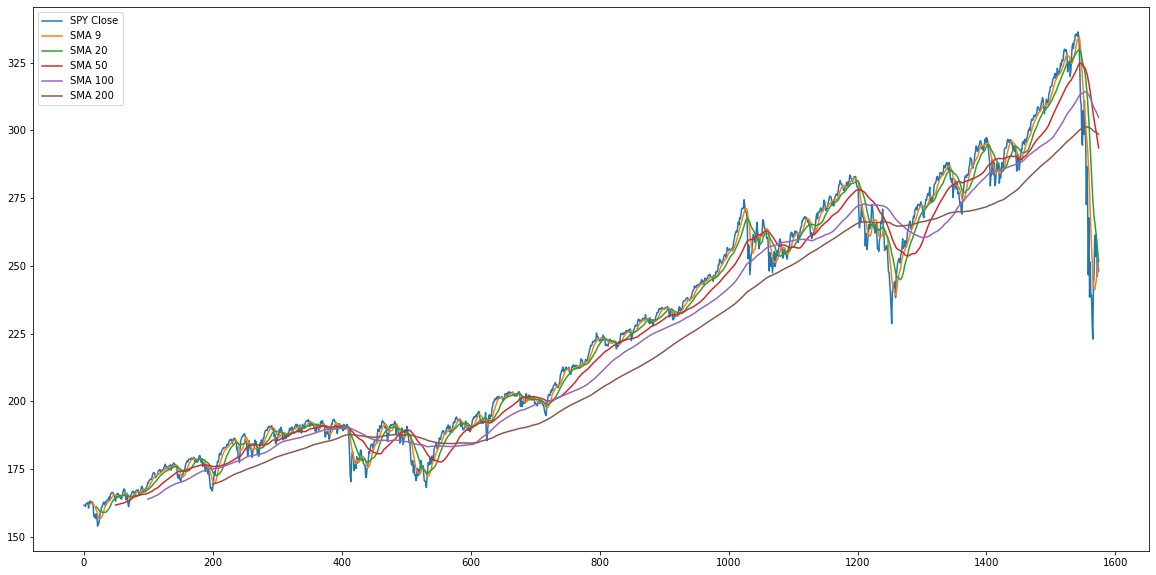

In [23]:
sma_close = spy_df[["Date", "SPY Close"]].set_index("Date")

spy_sma_9 = spy_px['SPY Close'].rolling(window=9).mean()
spy_sma_20 = spy_px['SPY Close'].rolling(window=20).mean()
spy_sma_50 = spy_px['SPY Close'].rolling(window=50).mean()
spy_sma_100 = spy_px['SPY Close'].rolling(window=100).mean()
spy_sma_200 = spy_px['SPY Close'].rolling(window=200).mean()

#sma_df = pd.concat([[spy_sma_9, spy_sma_20, spy_sma_50, spy_sma_100, spy_sma_200]])#, index_col="Date")
#sma_df.head(10)
#print(spy_sma_9[:20])

spy_px['SMA 9'] = pd.DataFrame(spy_sma_9)
spy_px['SMA 20'] = pd.DataFrame(spy_sma_20)
spy_px['SMA 50'] = pd.DataFrame(spy_sma_50)
spy_px['SMA 100'] = pd.DataFrame(spy_sma_100)
spy_px['SMA 200'] = pd.DataFrame(spy_sma_200)

#spy_close.tail()
spy_px[["SPY Close",'SMA 9','SMA 20', 'SMA 50', 'SMA 100', 'SMA 200']].plot(figsize=(20,10))

In [24]:
# Construct a crossover trading signal
spy_px['SMA Long'] = np.where(spy_px['SPY Close'] < spy_px['SMA 200'], 1.0, 0.0)
spy_px['SMA Short'] = np.where(spy_px['SPY Close'] > spy_px['SMA 200'] + 20, -1.0, 0.0)

# Construct MACD Signal
spy_px['SMA Signal'] = spy_px['SMA Long'] + spy_px['SMA Short']

In [25]:
spy_px.iloc[240:250, :]

,Date,SPY Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,...,RSI Short,RSI Signal,SMA 9,SMA 20,SMA 50,SMA 100,SMA 200,SMA Long,SMA Short,SMA Signal
240,12/15/2014,178.751190,202.529999,198.779999,184.289976,186.354651,182.225302,1.0,0.0,1.0,...,0.0,0.0,183.608263,184.289976,179.440194,177.929966,173.628700,0.0,0.0,0.0
241,12/16/2014,177.317673,202.399994,197.860001,184.000584,186.581178,181.419991,1.0,0.0,1.0,...,0.0,0.0,182.614749,184.000584,179.469223,177.939911,173.686532,0.0,0.0,0.0
242,12/17/2014,180.793991,202.339996,198.289993,183.832146,186.509717,181.154576,1.0,0.0,1.0,...,0.0,0.0,182.030390,183.832146,179.622072,177.983905,173.760994,0.0,0.0,0.0
243,12/18/2014,185.264770,212.970001,203.919998,183.902030,186.598732,181.205328,0.0,0.0,0.0,...,0.0,0.0,181.908939,183.902030,179.803772,178.080187,173.855911,0.0,0.0,0.0
244,12/19/2014,186.053070,207.330002,205.610001,183.995203,186.734224,181.256182,0.0,0.0,0.0,...,0.0,0.0,182.013451,183.995203,180.071120,178.184084,173.954415,0.0,0.0,0.0
245,12/22/2014,186.908920,207.470001,206.460007,184.081892,186.886865,181.276918,0.0,-1.0,-1.0,...,0.0,0.0,182.226995,184.081892,180.395008,178.331230,174.057641,0.0,0.0,0.0
246,12/23/2014,187.161148,208.229996,207.399994,184.155208,187.023018,181.287397,0.0,-1.0,-1.0,...,0.0,0.0,182.798077,184.155208,180.780026,178.486160,174.166237,0.0,0.0,0.0
247,12/24/2014,187.179169,208.339996,207.720001,184.236143,187.167830,181.304456,0.0,-1.0,-1.0,...,0.0,0.0,183.268617,184.236143,181.160208,178.628875,174.274702,0.0,0.0,0.0
248,12/26/2014,187.782776,208.850006,208.250000,184.323518,187.336560,181.310476,0.0,-1.0,-1.0,...,0.0,0.0,184.134745,184.323518,181.575221,178.794391,174.395463,0.0,0.0,0.0
249,12/29/2014,188.035049,208.970001,208.139999,184.443217,187.557217,181.329216,0.0,-1.0,-1.0,...,0.0,0.0,185.166285,184.443217,181.998146,178.961895,174.519783,0.0,0.0,0.0


## CCI

In [ ]:
# Commodity Channel Index Python Code

# Retrieve the SPY data from Yahoo finance:
data = spy_px
data = pdr.get_data_yahoo("SPY", start="2014-01-01", end="2021-04-06") 
data = pd.DataFrame(data)


# Commodity Channel Index 
def computeCCI(data, time_window): 
    TP = (data['High'] + data['Low'] + data['SPY Close']) / 3 
    CCI = pd.Series((TP - TP.rolling(time_window).mean()) / (0.015 * TP.rolling(time_window).std()), name = 'CCI')                   
    data = data.join(CCI) 
    data_df = pd.DataFrame(data['CCI'])
    return data_df


# Compute the Commodity Channel Index(CCI) for SPY based on the 14-day Moving average
#n = 14
#cci_df = CCI(data, n)


#cci_df[['CCI']].plot(figsize=(20,10))
spy_px['CCI'] = computeCCI(spy_px, 14)

In [30]:
# Construct a CCI trading signal
spy_px['CCI Long'] = np.where(spy_px['CCI'] < -175, 1.0, 0.0)
spy_px['CCI Short'] = np.where(spy_px['CCI'] > 150, -1.0, 0.0)

# Construct CCI Signal
spy_px['CCI Signal'] = spy_px['CCI Long'] + spy_px['CCI Short']

spy_px.tail(15)

,Date,SPY Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,...,SMA 50,SMA 100,SMA 200,SMA Long,SMA Short,SMA Signal,CCI,CCI Long,CCI Short,CCI Signal
1560,3/16/2020,238.447861,256.899994,237.360001,298.357572,326.372849,270.342296,1.0,0.0,1.0,...,315.705164,312.433323,300.941627,1.0,0.0,1.0,-131.679462,0.0,0.0,0.0
1561,3/17/2020,251.322159,256.170013,237.070007,294.185605,322.702669,265.668541,1.0,0.0,1.0,...,314.321103,311.988467,300.849447,1.0,0.0,1.0,-100.933778,0.0,0.0,0.0
1562,3/18/2020,238.596985,248.369995,228.020004,289.297350,318.573327,260.021372,1.0,0.0,1.0,...,312.658082,311.407754,300.697071,1.0,0.0,1.0,-106.884636,0.0,0.0,0.0
1563,3/19/2020,239.103989,247.380005,232.220001,284.503538,313.755087,255.251988,1.0,0.0,1.0,...,311.023294,310.827263,300.518027,1.0,0.0,1.0,-87.654240,0.0,0.0,0.0
1564,3/20/2020,228.800003,244.470001,228.500000,279.367012,308.943922,249.790102,1.0,0.0,1.0,...,309.148228,310.131563,300.275557,1.0,0.0,1.0,-87.520662,0.0,0.0,0.0
1565,3/23/2020,222.949997,229.679993,218.259995,274.487753,304.951706,244.023799,1.0,0.0,1.0,...,307.112420,309.360546,299.994820,1.0,0.0,1.0,-96.810480,0.0,0.0,0.0
1566,3/24/2020,243.149994,244.100006,233.800003,271.104139,301.074192,241.134086,0.0,0.0,0.0,...,305.499301,308.792419,299.801119,1.0,0.0,1.0,-49.120670,0.0,0.0,0.0
1567,3/25/2020,246.789993,256.350006,239.750000,267.959689,296.952688,238.966691,0.0,0.0,0.0,...,303.914445,308.251492,299.619151,1.0,0.0,1.0,-21.648942,0.0,0.0,0.0
1568,3/26/2020,261.200012,262.799988,249.050003,266.231151,294.500313,237.961989,0.0,0.0,0.0,...,302.627729,307.862678,299.509575,1.0,0.0,1.0,22.635125,0.0,0.0,0.0
1569,3/27/2020,253.419998,260.809998,251.050003,264.175745,291.765483,236.586008,0.0,0.0,0.0,...,301.170701,307.368265,299.363598,1.0,0.0,1.0,20.392729,0.0,0.0,0.0


### Trading Signal

In [31]:
spy_px.columns

Index(['Date', 'SPY Close', 'High', 'Low', 'bollinger_mid_band',
       'bollinger_upper_band', 'bollinger_lower_band', 'bollinger_long',
       'bollinger_short', 'bollinger_signal', 'macd 12d sma', 'macd 26d sma',
       'MACD Long', 'MACD Short', 'MACD Signal', 'RSI', 'RSI Long',
       'RSI Short', 'RSI Signal', 'SMA 9', 'SMA 20', 'SMA 50', 'SMA 100',
       'SMA 200', 'SMA Long', 'SMA Short', 'SMA Signal', 'CCI', 'CCI Long',
       'CCI Short', 'CCI Signal'],
      dtype='object')

In [32]:
spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']]

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-1.0,0.0,0.0
2,0.0,0.0,-1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
1570,0.0,0.0,-1.0,1.0,0.0
1571,0.0,0.0,-1.0,1.0,0.0
1572,0.0,0.0,-1.0,1.0,0.0
1573,0.0,0.0,-1.0,1.0,0.0


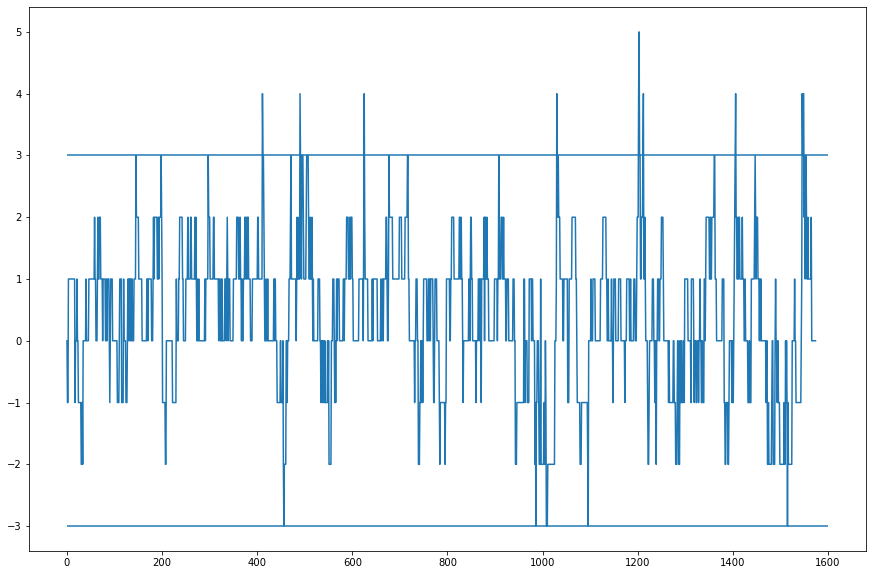

In [33]:
plt = spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']].sum(axis=1).plot(figsize=(15,10))
plt.hlines(3, xmin=0, xmax=1600)
plt.hlines(-3, xmin=0, xmax=1600)

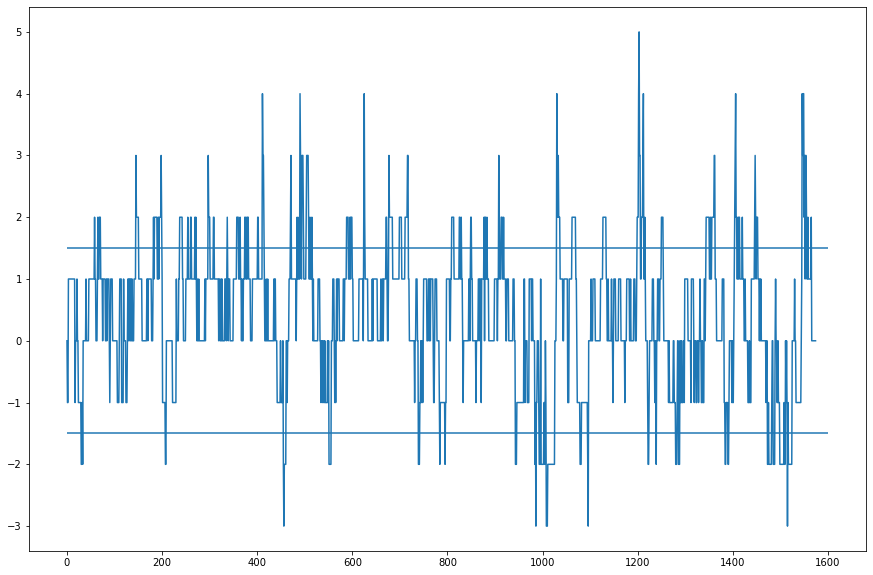

In [34]:
plt = spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']].sum(axis=1).plot(figsize=(15,10))
plt.hlines(1.5, xmin=0, xmax=1600)
plt.hlines(-1.5, xmin=0, xmax=1600)

In [35]:
spy_px['BUY_Signal'] = np.where(spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']].sum(axis=1) >= 3, 1.0, 0.0)
spy_px['SELL_Signal'] = np.where(spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']].sum(axis=1) <= -3, -1.0, 0.0)

In [36]:
print(spy_px.BUY_Signal.sum(), spy_px.SELL_Signal.sum())

41.0 -7.0


In [37]:
adam_spy_px = spy_px.copy()
adam_spy_px.set_index('Date', inplace=True)
adam_spy_px.index = pd.to_datetime(adam_spy_px.index, infer_datetime_format=True)

In [38]:
security_close = adam_spy_px['SPY Close'].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)



long = (adam_spy_px[adam_spy_px['BUY_Signal'] == 1.0]['SPY Close'] - 5).hvplot.scatter(
    marker="^",
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

short = (adam_spy_px[adam_spy_px['SELL_Signal'] == -1.0]['SPY Close'] + 5).hvplot.scatter(
    marker="v",
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)


entry_exit_plot = long * security_close * short
#entry_exit_plot.opts()
entry_exit_plot

:Overlay
   .Scatter.SPY_Close.I  :Scatter   [Date]   (SPY Close)
   .Curve.SPY_Close      :Curve   [Date]   (SPY Close)
   .Scatter.SPY_Close.II :Scatter   [Date]   (SPY Close)

In [39]:
cum_indicators = adam_spy_px.BUY_Signal.cumsum() + adam_spy_px.SELL_Signal.cumsum()

In [40]:
adam_spy_px.index

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03'],
              dtype='datetime64[ns]', name='Date', length=1575, freq=None)

In [41]:
trades = [0]
for i, position in enumerate(cum_indicators):
    if i == 0:
        continue
    
    elif adam_spy_px.BUY_Signal[i] > 0:
        trades.append(1)
        
    elif adam_spy_px.SELL_Signal[i] < 0:
        trades.append(-1)
        
    else:
        trades.append(trades[i-1])
    
indicators_df = pd.DataFrame(trades, index = adam_spy_px.index, columns=['trade'])

In [42]:
indicators_df['trade'].value_counts()

 1    1234
-1     196
 0     145
Name: trade, dtype: int64

In [43]:
indicators_df = indicators_df.diff().clip(-1,1)

In [44]:
indicators_df.iloc[0,:] = 0

In [45]:
indicators_df['trade'].value_counts()

 0.0    1566
 1.0       5
-1.0       4
Name: trade, dtype: int64

In [46]:
indicators_df

,trade
Date,
2014-01-02,0.0
2014-01-03,0.0
2014-01-06,0.0
2014-01-07,0.0
2014-01-08,0.0
...,...
2020-03-30,0.0
2020-03-31,0.0
2020-04-01,0.0


In [47]:
security_close = adam_spy_px['SPY Close'].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)



long = (adam_spy_px[indicators_df.trade == 1]['SPY Close'] - 5).hvplot.scatter(
    marker="^",
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

short = (adam_spy_px[indicators_df.trade == -1]['SPY Close'] + 5).hvplot.scatter(
    marker="v",
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)


entry_exit_plot = long * security_close * short
#entry_exit_plot.opts()
entry_exit_plot

:Overlay
   .Scatter.SPY_Close.I  :Scatter   [Date]   (SPY Close)
   .Curve.SPY_Close      :Curve   [Date]   (SPY Close)
   .Scatter.SPY_Close.II :Scatter   [Date]   (SPY Close)

In [ ]:
position.index = adam_spy_px.index
position['2019-10-23']

In [ ]:
position.plot()

In [76]:
adam_spy_px.SELL_Signal.cumsum()['2015-10-23']

-1.0

In [ ]:
adam_spy_px.loc['2018-10':'2018-11',['SPY Close','BUY Signal','RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']]

# Random Forest Trading

---

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [53]:
adam_spy_px.tail()

,SPY Close,High,Low,bollinger_mid_band,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,macd 12d sma,...,SMA 200,SMA Long,SMA Short,SMA Signal,CCI,CCI Long,CCI Short,CCI Signal,BUY_Signal,SELL_Signal
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,261.649994,262.429993,253.529999,261.894091,287.550420,236.237762,0.0,0.0,0.0,276.998577,...,299.252940,1.0,0.0,1.0,53.787828,0.0,0.0,0.0,0.0,0.0
2020-03-31,257.750000,263.329987,256.220001,259.857351,284.030002,235.684700,0.0,0.0,0.0,275.918237,...,299.124350,1.0,0.0,1.0,69.170111,0.0,0.0,0.0,0.0,0.0
2020-04-01,246.149994,257.660004,243.899994,256.613299,277.715422,235.511176,0.0,0.0,0.0,274.247474,...,298.937221,1.0,0.0,1.0,13.020643,0.0,0.0,0.0,0.0,0.0
2020-04-02,251.830002,252.679993,244.589996,254.170207,272.553954,235.786460,0.0,0.0,0.0,272.989278,...,298.763646,1.0,0.0,1.0,23.093336,0.0,0.0,0.0,0.0,0.0
2020-04-03,248.190002,253.320007,245.220001,251.793654,267.383140,236.204168,0.0,0.0,0.0,271.597402,...,298.568637,1.0,0.0,1.0,15.801508,0.0,0.0,0.0,0.0,0.0


In [54]:
signals_df = adam_spy_px[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']]
signals_df.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0


### Shift the DataFrame Index by 1

In [55]:
signals_shifted_df = signals_df.shift(1)
signals_shifted_df.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0


### Drop NAs and Replace Infs (Positive/Negative Infinity) 

In [56]:
# Drop NAs and replace positive/negative infinity values
signals_shifted_df.dropna(inplace=True)
#signals_shifted_df.dropna(subset=['daily_return'], inplace=True)
signals_inf_df = signals_shifted_df.replace([np.inf, -np.inf], np.nan)
signals_inf_df.head()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2014-01-03,0.0,0.0,0.0,0.0,0.0
2014-01-06,0.0,0.0,-1.0,0.0,0.0
2014-01-07,0.0,0.0,-1.0,0.0,0.0
2014-01-08,0.0,0.0,1.0,0.0,0.0
2014-01-09,0.0,0.0,1.0,0.0,0.0


### Construct the Dependent Variable

In [57]:
signals_inf_df['Trading_Signal'] = indicators_df['trade']
signals_inf_df.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal,Trading_Signal
Date,,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0,0.0


In [58]:
#signals_inf_df['Trading_Signal'] = indicators_df['trade']
signals_inf_df['Trading_Signal'].value_counts()

 0.0    1565
 1.0       5
-1.0       4
Name: Trading_Signal, dtype: int64

### Assign Training and Testing Windows

In [59]:
# Construct training start and end dates
training_start = signals_inf_df.index.min().strftime(format= '%Y-%m-%d')
training_end = '2018-05-17'

# Construct testing start and end dates
testing_start =  '2018-05-18'
testing_end = signals_inf_df.index.max().strftime(format= '%Y-%m-%d')

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2014-01-03
Training End: 2018-05-17
Testing Start: 2018-05-18
Testing End: 2020-04-03


### Separate X and Y Training Datasets

In [60]:
# Construct the x train and y train datasets
x_train = signals_inf_df[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']][training_start:training_end]
y_train = signals_inf_df['Trading_Signal'][training_start:training_end]

x_train.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2018-05-11,0.0,-1.0,-1.0,0.0,-1.0
2018-05-14,0.0,-1.0,1.0,0.0,0.0
2018-05-15,0.0,-1.0,1.0,0.0,0.0
2018-05-16,0.0,-1.0,1.0,0.0,0.0
2018-05-17,0.0,-1.0,1.0,0.0,0.0


In [79]:
y_train.tail()

Date
2018-05-11    0.0
2018-05-14    0.0
2018-05-15    0.0
2018-05-16    0.0
2018-05-17    0.0
Name: Trading_Signal, dtype: float64

### Separate X and Y Testing Datasets

In [80]:
# Construct the x train and y train datasets
x_test = signals_inf_df[['RSI Signal', 'bollinger_signal', 'MACD Signal', 'SMA Signal', 'CCI Signal']][testing_start:testing_end]
y_test = signals_inf_df['Trading_Signal'][testing_start:testing_end]

x_test.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0


In [81]:
y_test.tail()

Date
2020-03-30    0.0
2020-03-31    0.0
2020-04-01    0.0
2020-04-02    0.0
2020-04-03    0.0
Name: Trading_Signal, dtype: float64

### Import SKLearn Library and Classes

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### Train Random Forest Model 

In [84]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted_Signals"] = predictions
Results.tail()

,Trading_Signal,Predicted_Signals
Date,,
2020-03-30,0.0,0.0
2020-03-31,0.0,0.0
2020-04-01,0.0,0.0
2020-04-02,0.0,0.0
2020-04-03,0.0,0.0


### Save Pre-Trained Model Using Joblib

In [85]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [86]:
x_test.head()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal
Date,,,,,
2018-05-18,0.0,-1.0,1.0,0.0,0.0
2018-05-21,0.0,0.0,1.0,0.0,0.0
2018-05-22,0.0,-1.0,1.0,0.0,0.0
2018-05-23,0.0,-1.0,1.0,0.0,0.0
2018-05-24,0.0,-1.0,1.0,0.0,0.0


In [87]:
y_test.head()

Date
2018-05-18    0.0
2018-05-21    0.0
2018-05-22    0.0
2018-05-23    0.0
2018-05-24    0.0
Name: Trading_Signal, dtype: float64

In [88]:
trading_df = adam_spy_px[["SPY Close"]].loc["2018-05-18":"2020-04-03"]
trading_df.head()

,SPY Close
Date,
2018-05-18,260.836639
2018-05-21,262.797730
2018-05-22,262.067108
2018-05-23,262.788147
2018-05-24,262.249786


In [89]:
trading_df["Return"] = trading_df["SPY Close"].pct_change()
trading_df.fillna(0, inplace=True)
trading_df.head()

,SPY Close,Return
Date,,
2018-05-18,260.836639,0.000000
2018-05-21,262.797730,0.007518
2018-05-22,262.067108,-0.002780
2018-05-23,262.788147,0.002751
2018-05-24,262.249786,-0.002049


In [90]:
trading_df.columns

Index(['SPY Close', 'Return'], dtype='object')

### Compare Predicted Results to Y-Test (Actual Results)

In [91]:
#recreate results from the exercise
trading_df["Trading_Signal"] = Results['Trading_Signal']
trading_df['Predicted_Signal'] = Results['Predicted_Signals']
trading_df.head()

,SPY Close,Return,Trading_Signal,Predicted_Signal
Date,,,,
2018-05-18,260.836639,0.000000,0.0,0.0
2018-05-21,262.797730,0.007518,0.0,0.0
2018-05-22,262.067108,-0.002780,0.0,0.0
2018-05-23,262.788147,0.002751,0.0,0.0
2018-05-24,262.249786,-0.002049,0.0,0.0


### Plot Cumulative Return of Random Forest Model (In Terms of Capital)

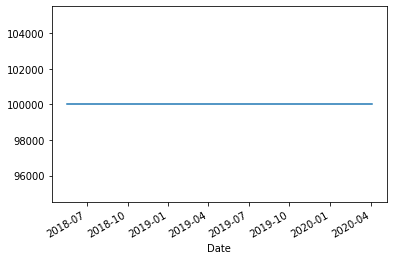

In [92]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (trading_df['Return'] * trading_df['Predicted_Signal'])).cumprod()
cumulative_return_capital.plot()

In [93]:
Results.head()

,Trading_Signal,Predicted_Signals
Date,,
2018-05-18,0.0,0.0
2018-05-21,0.0,0.0
2018-05-22,0.0,0.0
2018-05-23,0.0,0.0
2018-05-24,0.0,0.0


In [94]:
signals_inf_df.head()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal,Trading_Signal
Date,,,,,,
2014-01-03,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-06,0.0,0.0,-1.0,0.0,0.0,0.0
2014-01-07,0.0,0.0,-1.0,0.0,0.0,0.0
2014-01-08,0.0,0.0,1.0,0.0,0.0,0.0
2014-01-09,0.0,0.0,1.0,0.0,0.0,0.0


In [95]:
signals_inf_df.tail()

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal,Trading_Signal
Date,,,,,,
2020-03-30,0.0,0.0,-1.0,1.0,0.0,0.0
2020-03-31,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-01,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-02,0.0,0.0,-1.0,1.0,0.0,0.0
2020-04-03,0.0,0.0,-1.0,1.0,0.0,0.0


In [96]:
signals_inf_df["RSI Signal"].count()

1574

In [97]:
signals_inf_df.iloc[1100:1102, :]

,RSI Signal,bollinger_signal,MACD Signal,SMA Signal,CCI Signal,Trading_Signal
Date,,,,,,
2018-05-17,0.0,-1.0,1.0,0.0,0.0,0.0
2018-05-18,0.0,-1.0,1.0,0.0,0.0,0.0


In [98]:
1574 * .7

1101.8